In [1]:
import os
import requests
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize API
api = KaggleApi()
api.authenticate()

# Download dataset
dataset = 'paulbrabban/daily-minimum-temperatures-in-melbourne'
api.dataset_download_files(dataset, path='./', unzip=True)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [3]:
file = './daily-minimum-temperatures-in-me.csv'

melbourne_temp_df = pd.read_csv(file, 
                                parse_dates=[0],
                                skiprows=[3652],  # skipping row 3652 as there is some bad data there
                                on_bad_lines='skip')  # or 'warn' if you want to see the warnings

melbourne_temp_df.head()


,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
melbourne_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           3650 non-null   datetime64[ns]
 1   Daily minimum temperatures in Melbourne, Australia, 1981-1990  3650 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 57.2+ KB


In [5]:
melbourne_temp_df.isnull().sum()

Date                                                             0
Daily minimum temperatures in Melbourne, Australia, 1981-1990    0
dtype: int64

In [6]:
not_digit_df = melbourne_temp_df[~melbourne_temp_df['Daily minimum temperatures in Melbourne, Australia, 1981-1990'].str[0].str.isdigit()]

not_digit_df

,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
565,1982-07-20,?0.2
566,1982-07-21,?0.8
1290,1984-07-14,?0.1


In [7]:
print("There are ", len(melbourne_temp_df['Date'].dt.year.unique()), " Unique Years in this dataset. \n")
print(melbourne_temp_df['Date'].dt.year.unique())

There are  10  Unique Years in this dataset. 

[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990]


In [8]:
melbourne_temp_df = melbourne_temp_df.rename(columns={'Daily minimum temperatures in Melbourne, Australia, 1981-1990' : 'Temp'})

melbourne_temp_df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [9]:
# Let us remove the question mark
melbourne_temp_df['Temp'] = melbourne_temp_df['Temp'].apply(lambda x:x.replace('?', ''))

# Converting the Temp Column  to Float
melbourne_temp_df['Temp'] = melbourne_temp_df['Temp'].astype(float)

In [10]:
melbourne_temp_df[melbourne_temp_df['Date'].isin(["1982-07-20","1982-07-21", "1984-07-14"])]

,Date,Temp
565,1982-07-20,0.2
566,1982-07-21,0.8
1290,1984-07-14,0.1


In [11]:
melbourne_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [12]:
melbourne_temp_df.describe()

,Date,Temp
count,3650,3650.000000
mean,1985-12-31 07:12:00,11.177753
min,1981-01-01 00:00:00,0.000000
25%,1983-07-02 06:00:00,8.300000
50%,1985-12-31 12:00:00,11.000000
75%,1988-06-30 18:00:00,14.000000
max,1990-12-31 00:00:00,26.300000
std,NaN,4.071837


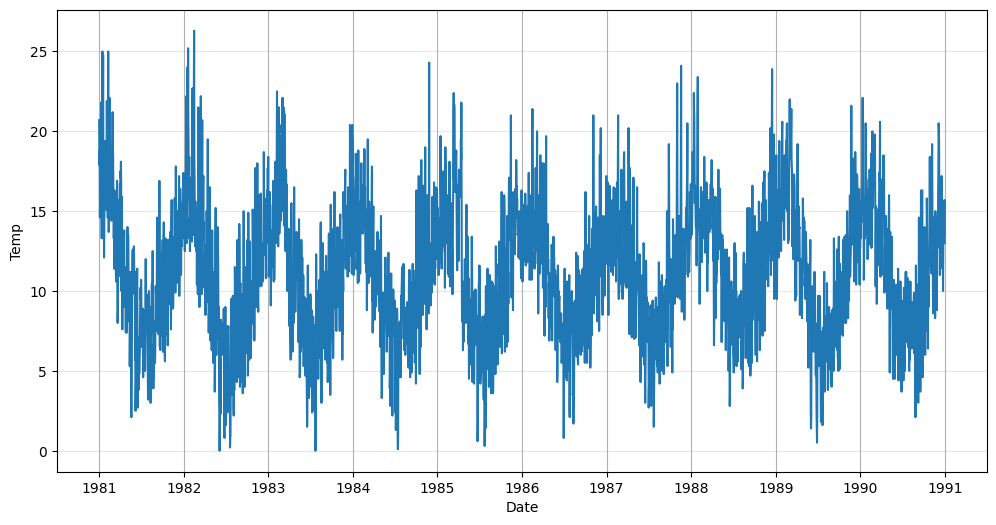

In [13]:
# A Lineplot of the dataset
plt.figure(figsize=(12,6))
sns.lineplot(x=melbourne_temp_df['Date'], y=melbourne_temp_df['Temp'])
plt.grid(axis='x')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [14]:
def get_trend(timeseries, deg=3):
    
  x = list(range(len(timeseries)))

  y = timeseries.values
    
  coef = np.polyfit(x, y, deg)

  trend = np.poly1d(coef)(x)
    
  return pd.Series(data=trend, index = timeseries.index)

# Creating the Trend Column

melbourne_temp_df['Trend'] = get_trend(melbourne_temp_df['Temp'])

melbourne_temp_df.head()

,Date,Temp,Trend
0,1981-01-01,20.7,12.591767
1,1981-01-02,17.9,12.587840
2,1981-01-03,18.8,12.583918
3,1981-01-04,14.6,12.580001
4,1981-01-05,15.8,12.576088


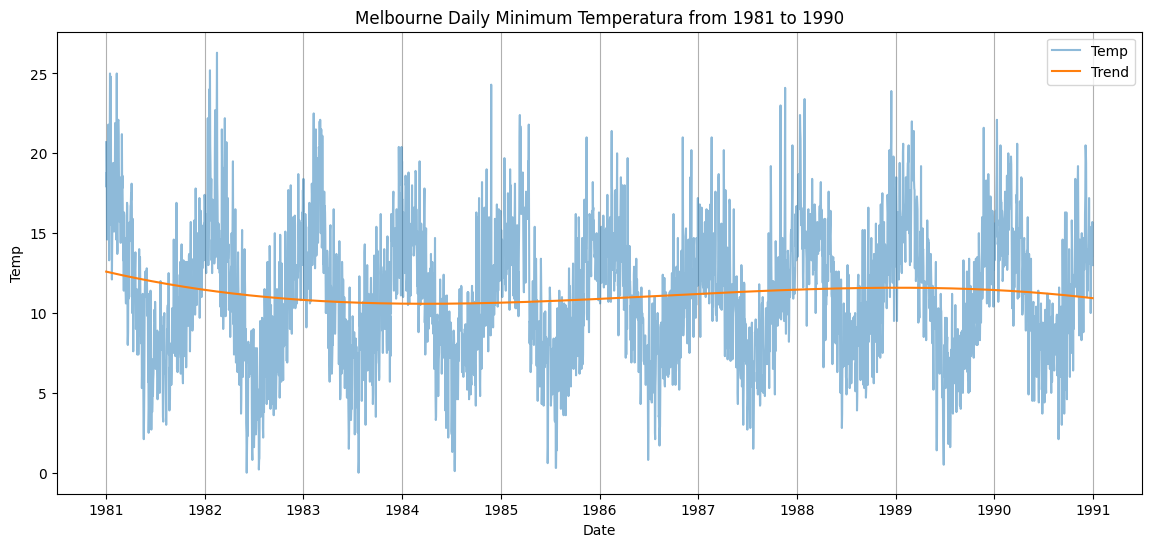

In [15]:
plt.figure(figsize=(14,6))

sns.lineplot(x=melbourne_temp_df['Date'], y=melbourne_temp_df['Temp'], alpha=0.5, label='Temp')

sns.lineplot(x=melbourne_temp_df['Date'], y=melbourne_temp_df['Trend'], label='Trend')

plt.grid(axis='x')

plt.title("Melbourne Daily Minimum Temperatura from 1981 to 1990")

plt.legend()
 
plt.show()

In [16]:
melbourne_temp_df.head()

,Date,Temp,Trend
0,1981-01-01,20.7,12.591767
1,1981-01-02,17.9,12.587840
2,1981-01-03,18.8,12.583918
3,1981-01-04,14.6,12.580001
4,1981-01-05,15.8,12.576088


In [17]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm 
import matplotlib.pyplot as plt

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

SPLIT_TIME = 2500
WINDOW_SIZE = 64
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [19]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [20]:
def train_val_split(time, series, time_step=SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


class TimeseriesDataset(Dataset):   
    def __init__(self, series, window_size=WINDOW_SIZE):
        self.series = series
        self.window_size = window_size

    def __len__(self):
        return self.series.__len__() - (self.window_size) - 1

    def __getitem__(self, index):
        return (self.series[index:index+self.window_size], self.series[index+self.window_size])

In [21]:
# Split the dataset
time_train, y_train, time_valid, y_val = train_val_split(melbourne_temp_df['Date'], melbourne_temp_df['Temp'])

# Apply the transformation to the training set
train_ds = TimeseriesDataset(y_train.values.astype(np.float32), window_size=WINDOW_SIZE)
train_dl = torch.utils.data.DataLoader(train_ds,
                                         batch_size = BATCH_SIZE,
                                         shuffle = True,
                                         num_workers = 1)



valid_ds = TimeseriesDataset(y_val.values.astype(np.float32), window_size=WINDOW_SIZE)
valid_dl = torch.utils.data.DataLoader(valid_ds,
                                         batch_size = BATCH_SIZE,
                                         shuffle = True,
                                         num_workers = 1)

In [22]:
class CausalConv1d(nn.Conv1d):
    """causal convolution based on https://github.com/pytorch/pytorch/issues/1333#issuecomment-310929585
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)

        self.left_padding = dilation * (kernel_size - 1)

    def forward(self, input):
        x = F.pad(input.unsqueeze(2), (self.left_padding, 0, 0, 0)).squeeze(2)

        return super(CausalConv1d, self).forward(x)

In [23]:
class TimeSeriesModel(nn.Module):

    def __init__(self, window_size=WINDOW_SIZE):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.conv_1 = CausalConv1d(in_channels=window_size, 
                                   out_channels=32,
                                   kernel_size=3,
                                   stride=1)
        
        self.activation_1 = nn.ReLU()
        
        # Replacing LSTM with GRU
        self.gru = nn.GRU(input_size=32, hidden_size=32, num_layers=2)

        self.linear_1 = nn.Linear(32, 16)
        self.activation_2 = nn.ReLU()
        self.linear_2 = nn.Linear(16, 16)
        self.activation_3 = nn.ReLU()
        self.linear_3 = nn.Linear(16, 1)

    def forward(self, x):
        
        x = self.conv_1(x)
        x = self.activation_1(x)

        # Adjusting for GRU
        x, _ = self.gru(x.squeeze(-1))
    
        x = self.linear_1(x)
        x = self.activation_2(x)

        x = self.linear_2(x)
        x = self.activation_3(x)

        x = self.linear_3(x)

        return x


In [24]:
model = TimeSeriesModel(window_size=WINDOW_SIZE).to(device)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesModel(window_size=WINDOW_SIZE).to(device)
x, y = next(iter(train_dl))
x, y = x.to(device), y.to(device)
out = model(x)


# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = out.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

In [26]:
def adjust_learning_rate(dataloader):
    
    history = {}
    
    model = TimeSeriesModel(window_size=WINDOW_SIZE).to(device)
    
    criterion = nn.HuberLoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=1E-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.1)


    optimizer.zero_grad()

    # Push the data forward through the model layers
    
    epochs = 100

    history = {"loss": [], "lr": []}
    for epoch in tqdm(range(epochs)):
        
        avg_loss = []
        for batch_idx, (data, target) in enumerate(dataloader):

            data, target = data.to(device), target.to(device)

            output = model(data)

            # Get the loss
            loss = criterion(output.squeeze(), target)
            lr = scheduler.get_last_lr()
            avg_loss.append(float(loss))

        _loss = np.mean(avg_loss)
        history['loss'].append(_loss)
        history['lr'].append(lr[0])
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    return history

In [27]:
history = adjust_learning_rate(train_dl)

100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


(0.0001, 1.0, 0.0, 20.0)

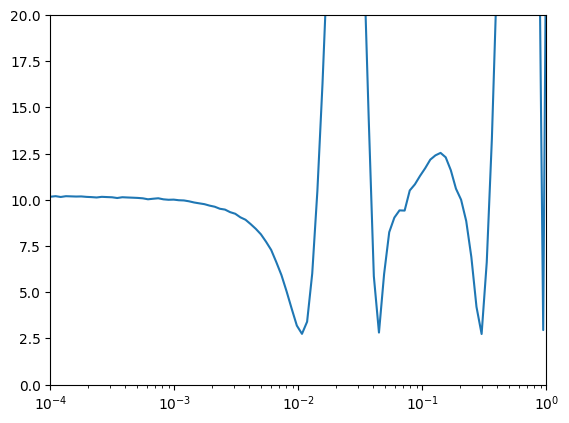

In [28]:
plt.semilogx(history["lr"], history["loss"])
plt.axis([1e-4, 1, 0, 20])

In [29]:
def train(model, device, train_loader, optimizer, scheduler, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        output = output.squeeze()
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()

        optimizer.step()
    scheduler.step()
        
        # Print metrics so we see some progress
#         print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()), end='\r')

    avg_loss = train_loss / (batch_idx+1)
    print('\nTraining set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss


def validation(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    mae = []
    with torch.no_grad():
        batch_count = 0
        for data, target in tqdm(test_loader):
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            output = output.squeeze()
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            mae.extend(torch.abs(output - target).cpu().numpy())
                
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    
    print(f'Validation set: Average loss: {avg_loss:.4f}, MAE: {float(sum(mae)/len(mae)):.4f}')
    # return average loss for the epoch
    return avg_loss

In [30]:
model = TimeSeriesModel(window_size=WINDOW_SIZE).to(device)

criterion = nn.HuberLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
optimizer.zero_grad()

In [31]:
early_stopping = 10
tolerance = 0.0001

epoch_nums = []
training_loss = []
validation_loss = []

epochs = 100

early_stopping_count = 0
min_loss = float('inf')
best_model_params_path = "best_model_params.pt"  # Saving in the current working directory

print('Training on', device)

for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_dl, optimizer, scheduler, epoch)
    val_loss = validation(model, device, valid_dl)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)

    if val_loss > (min_loss - tolerance):
        early_stopping_count += 1
    else:
        min_loss = val_loss
        early_stopping_count = 0
        torch.save(model.state_dict(), best_model_params_path)  # Save the best model state

    if early_stopping_count >= early_stopping:
        break

# Load the best model state for evaluation or further training
model.load_state_dict(torch.load(best_model_params_path))

Training on cuda
Epoch: 1


100%|██████████| 77/77 [00:00<00:00, 200.56it/s]



Training set: Average loss: 5.073986


100%|██████████| 34/34 [00:00<00:00, 304.31it/s]


Validation set: Average loss: 2.9176, MAE: 3.3905
Epoch: 2


100%|██████████| 77/77 [00:00<00:00, 217.46it/s]



Training set: Average loss: 2.728268


100%|██████████| 34/34 [00:00<00:00, 260.66it/s]


Validation set: Average loss: 2.8404, MAE: 3.3112
Epoch: 3


100%|██████████| 77/77 [00:00<00:00, 204.27it/s]



Training set: Average loss: 2.738363


100%|██████████| 34/34 [00:00<00:00, 287.17it/s]


Validation set: Average loss: 2.8382, MAE: 3.3097
Epoch: 4


100%|██████████| 77/77 [00:00<00:00, 196.61it/s]



Training set: Average loss: 2.763826


100%|██████████| 34/34 [00:00<00:00, 284.03it/s]


Validation set: Average loss: 2.9406, MAE: 3.4112
Epoch: 5


100%|██████████| 77/77 [00:00<00:00, 233.74it/s]



Training set: Average loss: 2.751787


100%|██████████| 34/34 [00:00<00:00, 302.15it/s]


Validation set: Average loss: 2.9436, MAE: 3.4147
Epoch: 6


100%|██████████| 77/77 [00:00<00:00, 192.88it/s]



Training set: Average loss: 2.719020


100%|██████████| 34/34 [00:00<00:00, 310.22it/s]


Validation set: Average loss: 2.9433, MAE: 3.4155
Epoch: 7


100%|██████████| 77/77 [00:00<00:00, 219.67it/s]



Training set: Average loss: 2.714763


100%|██████████| 34/34 [00:00<00:00, 300.34it/s]


Validation set: Average loss: 2.9246, MAE: 3.3958
Epoch: 8


100%|██████████| 77/77 [00:00<00:00, 227.60it/s]



Training set: Average loss: 2.733989


100%|██████████| 34/34 [00:00<00:00, 281.56it/s]


Validation set: Average loss: 2.9375, MAE: 3.4099
Epoch: 9


100%|██████████| 77/77 [00:00<00:00, 195.35it/s]



Training set: Average loss: 2.729619


100%|██████████| 34/34 [00:00<00:00, 263.79it/s]


Validation set: Average loss: 2.9667, MAE: 3.4370
Epoch: 10


100%|██████████| 77/77 [00:00<00:00, 198.68it/s]



Training set: Average loss: 2.694532


100%|██████████| 34/34 [00:00<00:00, 259.67it/s]


Validation set: Average loss: 2.9883, MAE: 3.4586
Epoch: 11


100%|██████████| 77/77 [00:00<00:00, 182.26it/s]



Training set: Average loss: 2.443742


100%|██████████| 34/34 [00:00<00:00, 223.69it/s]


Validation set: Average loss: 1.9101, MAE: 2.3624
Epoch: 12


100%|██████████| 77/77 [00:00<00:00, 173.40it/s]



Training set: Average loss: 1.980562


100%|██████████| 34/34 [00:00<00:00, 170.82it/s]


Validation set: Average loss: 2.2612, MAE: 2.7226
Epoch: 13


100%|██████████| 77/77 [00:00<00:00, 160.34it/s]



Training set: Average loss: 1.931659


100%|██████████| 34/34 [00:00<00:00, 191.58it/s]


Validation set: Average loss: 1.7632, MAE: 2.2108
Epoch: 14


100%|██████████| 77/77 [00:00<00:00, 161.18it/s]



Training set: Average loss: 1.923111


100%|██████████| 34/34 [00:00<00:00, 210.43it/s]


Validation set: Average loss: 1.6267, MAE: 2.0702
Epoch: 15


100%|██████████| 77/77 [00:00<00:00, 174.63it/s]



Training set: Average loss: 1.860007


100%|██████████| 34/34 [00:00<00:00, 229.57it/s]


Validation set: Average loss: 1.7094, MAE: 2.1569
Epoch: 16


100%|██████████| 77/77 [00:00<00:00, 176.01it/s]



Training set: Average loss: 1.811725


100%|██████████| 34/34 [00:00<00:00, 216.40it/s]


Validation set: Average loss: 1.6737, MAE: 2.1282
Epoch: 17


100%|██████████| 77/77 [00:00<00:00, 196.21it/s]



Training set: Average loss: 1.789855


100%|██████████| 34/34 [00:00<00:00, 256.29it/s]


Validation set: Average loss: 1.6040, MAE: 2.0463
Epoch: 18


100%|██████████| 77/77 [00:00<00:00, 216.70it/s]



Training set: Average loss: 1.755486


100%|██████████| 34/34 [00:00<00:00, 271.16it/s]


Validation set: Average loss: 1.6199, MAE: 2.0680
Epoch: 19


100%|██████████| 77/77 [00:00<00:00, 202.33it/s]



Training set: Average loss: 1.724193


100%|██████████| 34/34 [00:00<00:00, 281.59it/s]


Validation set: Average loss: 1.6262, MAE: 2.0715
Epoch: 20


100%|██████████| 77/77 [00:00<00:00, 212.76it/s]



Training set: Average loss: 1.732869


100%|██████████| 34/34 [00:00<00:00, 186.25it/s]


Validation set: Average loss: 1.6130, MAE: 2.0551
Epoch: 21


100%|██████████| 77/77 [00:00<00:00, 188.44it/s]



Training set: Average loss: 1.645783


100%|██████████| 34/34 [00:00<00:00, 259.71it/s]


Validation set: Average loss: 1.6255, MAE: 2.0752
Epoch: 22


100%|██████████| 77/77 [00:00<00:00, 197.89it/s]



Training set: Average loss: 1.649201


100%|██████████| 34/34 [00:00<00:00, 247.39it/s]


Validation set: Average loss: 1.5430, MAE: 1.9847
Epoch: 23


100%|██████████| 77/77 [00:00<00:00, 199.02it/s]



Training set: Average loss: 1.633743


100%|██████████| 34/34 [00:00<00:00, 216.06it/s]


Validation set: Average loss: 1.5726, MAE: 2.0128
Epoch: 24


100%|██████████| 77/77 [00:00<00:00, 195.12it/s]



Training set: Average loss: 1.604868


100%|██████████| 34/34 [00:00<00:00, 233.20it/s]


Validation set: Average loss: 1.5776, MAE: 2.0252
Epoch: 25


100%|██████████| 77/77 [00:00<00:00, 215.83it/s]



Training set: Average loss: 1.607315


100%|██████████| 34/34 [00:00<00:00, 281.57it/s]


Validation set: Average loss: 1.4807, MAE: 1.9191
Epoch: 26


100%|██████████| 77/77 [00:00<00:00, 190.90it/s]



Training set: Average loss: 1.584289


100%|██████████| 34/34 [00:00<00:00, 231.21it/s]


Validation set: Average loss: 1.4706, MAE: 1.9065
Epoch: 27


100%|██████████| 77/77 [00:00<00:00, 173.53it/s]



Training set: Average loss: 1.576243


100%|██████████| 34/34 [00:00<00:00, 203.77it/s]


Validation set: Average loss: 1.4888, MAE: 1.9268
Epoch: 28


100%|██████████| 77/77 [00:00<00:00, 171.04it/s]



Training set: Average loss: 1.603221


100%|██████████| 34/34 [00:00<00:00, 223.38it/s]


Validation set: Average loss: 1.4763, MAE: 1.9163
Epoch: 29


100%|██████████| 77/77 [00:00<00:00, 189.04it/s]



Training set: Average loss: 1.596455


100%|██████████| 34/34 [00:00<00:00, 220.09it/s]


Validation set: Average loss: 1.4458, MAE: 1.8853
Epoch: 30


100%|██████████| 77/77 [00:00<00:00, 179.24it/s]



Training set: Average loss: 1.571362


100%|██████████| 34/34 [00:00<00:00, 225.27it/s]


Validation set: Average loss: 1.4956, MAE: 1.9426
Epoch: 31


100%|██████████| 77/77 [00:00<00:00, 186.54it/s]



Training set: Average loss: 1.536800


100%|██████████| 34/34 [00:00<00:00, 251.42it/s]


Validation set: Average loss: 1.4535, MAE: 1.8953
Epoch: 32


100%|██████████| 77/77 [00:00<00:00, 189.70it/s]



Training set: Average loss: 1.534004


100%|██████████| 34/34 [00:00<00:00, 262.12it/s]


Validation set: Average loss: 1.4983, MAE: 1.9368
Epoch: 33


100%|██████████| 77/77 [00:00<00:00, 180.12it/s]



Training set: Average loss: 1.526929


100%|██████████| 34/34 [00:00<00:00, 216.09it/s]


Validation set: Average loss: 1.4548, MAE: 1.8915
Epoch: 34


100%|██████████| 77/77 [00:00<00:00, 157.78it/s]



Training set: Average loss: 1.532961


100%|██████████| 34/34 [00:00<00:00, 224.27it/s]


Validation set: Average loss: 1.4721, MAE: 1.9165
Epoch: 35


100%|██████████| 77/77 [00:00<00:00, 172.29it/s]



Training set: Average loss: 1.515432


100%|██████████| 34/34 [00:00<00:00, 209.52it/s]


Validation set: Average loss: 1.4807, MAE: 1.9198
Epoch: 36


100%|██████████| 77/77 [00:00<00:00, 192.31it/s]



Training set: Average loss: 1.541302


100%|██████████| 34/34 [00:00<00:00, 239.84it/s]


Validation set: Average loss: 1.4338, MAE: 1.8758
Epoch: 37


100%|██████████| 77/77 [00:00<00:00, 200.04it/s]



Training set: Average loss: 1.514729


100%|██████████| 34/34 [00:00<00:00, 241.71it/s]


Validation set: Average loss: 1.4266, MAE: 1.8679
Epoch: 38


100%|██████████| 77/77 [00:00<00:00, 190.98it/s]



Training set: Average loss: 1.517505


100%|██████████| 34/34 [00:00<00:00, 211.84it/s]


Validation set: Average loss: 1.4392, MAE: 1.8817
Epoch: 39


100%|██████████| 77/77 [00:00<00:00, 202.70it/s]



Training set: Average loss: 1.495268


100%|██████████| 34/34 [00:00<00:00, 260.23it/s]


Validation set: Average loss: 1.4428, MAE: 1.8798
Epoch: 40


100%|██████████| 77/77 [00:00<00:00, 216.99it/s]



Training set: Average loss: 1.487189


100%|██████████| 34/34 [00:00<00:00, 253.46it/s]


Validation set: Average loss: 1.4415, MAE: 1.8820
Epoch: 41


100%|██████████| 77/77 [00:00<00:00, 202.96it/s]



Training set: Average loss: 1.480206


100%|██████████| 34/34 [00:00<00:00, 226.92it/s]


Validation set: Average loss: 1.4919, MAE: 1.9338
Epoch: 42


100%|██████████| 77/77 [00:00<00:00, 208.14it/s]



Training set: Average loss: 1.493147


100%|██████████| 34/34 [00:00<00:00, 202.22it/s]


Validation set: Average loss: 1.4238, MAE: 1.8647
Epoch: 43


100%|██████████| 77/77 [00:00<00:00, 195.02it/s]



Training set: Average loss: 1.490624


100%|██████████| 34/34 [00:00<00:00, 247.98it/s]


Validation set: Average loss: 1.4192, MAE: 1.8552
Epoch: 44


100%|██████████| 77/77 [00:00<00:00, 176.71it/s]



Training set: Average loss: 1.479700


100%|██████████| 34/34 [00:00<00:00, 265.40it/s]


Validation set: Average loss: 1.4363, MAE: 1.8762
Epoch: 45


100%|██████████| 77/77 [00:00<00:00, 176.78it/s]



Training set: Average loss: 1.463593


100%|██████████| 34/34 [00:00<00:00, 256.51it/s]


Validation set: Average loss: 1.4267, MAE: 1.8678
Epoch: 46


100%|██████████| 77/77 [00:00<00:00, 178.03it/s]



Training set: Average loss: 1.488321


100%|██████████| 34/34 [00:00<00:00, 225.30it/s]


Validation set: Average loss: 1.3997, MAE: 1.8367
Epoch: 47


100%|██████████| 77/77 [00:00<00:00, 176.94it/s]



Training set: Average loss: 1.482837


100%|██████████| 34/34 [00:00<00:00, 197.25it/s]


Validation set: Average loss: 1.4098, MAE: 1.8479
Epoch: 48


100%|██████████| 77/77 [00:00<00:00, 178.61it/s]



Training set: Average loss: 1.484179


100%|██████████| 34/34 [00:00<00:00, 204.24it/s]


Validation set: Average loss: 1.4390, MAE: 1.8765
Epoch: 49


100%|██████████| 77/77 [00:00<00:00, 184.15it/s]



Training set: Average loss: 1.486844


100%|██████████| 34/34 [00:00<00:00, 200.75it/s]


Validation set: Average loss: 1.5573, MAE: 2.0050
Epoch: 50


100%|██████████| 77/77 [00:00<00:00, 173.53it/s]



Training set: Average loss: 1.499884


100%|██████████| 34/34 [00:00<00:00, 204.36it/s]


Validation set: Average loss: 1.4181, MAE: 1.8566
Epoch: 51


100%|██████████| 77/77 [00:00<00:00, 176.67it/s]



Training set: Average loss: 1.478505


100%|██████████| 34/34 [00:00<00:00, 177.57it/s]


Validation set: Average loss: 1.3961, MAE: 1.8325
Epoch: 52


100%|██████████| 77/77 [00:00<00:00, 173.15it/s]



Training set: Average loss: 1.470504


100%|██████████| 34/34 [00:00<00:00, 213.88it/s]


Validation set: Average loss: 1.4332, MAE: 1.8730
Epoch: 53


100%|██████████| 77/77 [00:00<00:00, 197.02it/s]



Training set: Average loss: 1.498665


100%|██████████| 34/34 [00:00<00:00, 234.32it/s]


Validation set: Average loss: 1.4049, MAE: 1.8422
Epoch: 54


100%|██████████| 77/77 [00:00<00:00, 205.80it/s]



Training set: Average loss: 1.462448


100%|██████████| 34/34 [00:00<00:00, 228.32it/s]


Validation set: Average loss: 1.4076, MAE: 1.8437
Epoch: 55


100%|██████████| 77/77 [00:00<00:00, 176.81it/s]



Training set: Average loss: 1.460914


100%|██████████| 34/34 [00:00<00:00, 245.85it/s]


Validation set: Average loss: 1.4079, MAE: 1.8465
Epoch: 56


100%|██████████| 77/77 [00:00<00:00, 191.97it/s]



Training set: Average loss: 1.453203


100%|██████████| 34/34 [00:00<00:00, 233.29it/s]


Validation set: Average loss: 1.4308, MAE: 1.8697
Epoch: 57


100%|██████████| 77/77 [00:00<00:00, 213.33it/s]



Training set: Average loss: 1.469034


100%|██████████| 34/34 [00:00<00:00, 227.35it/s]


Validation set: Average loss: 1.4060, MAE: 1.8431
Epoch: 58


100%|██████████| 77/77 [00:00<00:00, 197.58it/s]



Training set: Average loss: 1.479509


100%|██████████| 34/34 [00:00<00:00, 246.23it/s]


Validation set: Average loss: 1.4040, MAE: 1.8453
Epoch: 59


100%|██████████| 77/77 [00:00<00:00, 213.95it/s]



Training set: Average loss: 1.503737


100%|██████████| 34/34 [00:00<00:00, 217.86it/s]


Validation set: Average loss: 1.4121, MAE: 1.8508
Epoch: 60


100%|██████████| 77/77 [00:00<00:00, 205.67it/s]



Training set: Average loss: 1.458860


100%|██████████| 34/34 [00:00<00:00, 279.07it/s]


Validation set: Average loss: 1.3980, MAE: 1.8391
Epoch: 61


100%|██████████| 77/77 [00:00<00:00, 205.44it/s]



Training set: Average loss: 1.467800


100%|██████████| 34/34 [00:00<00:00, 271.86it/s]


Validation set: Average loss: 1.4044, MAE: 1.8391


<All keys matched successfully>

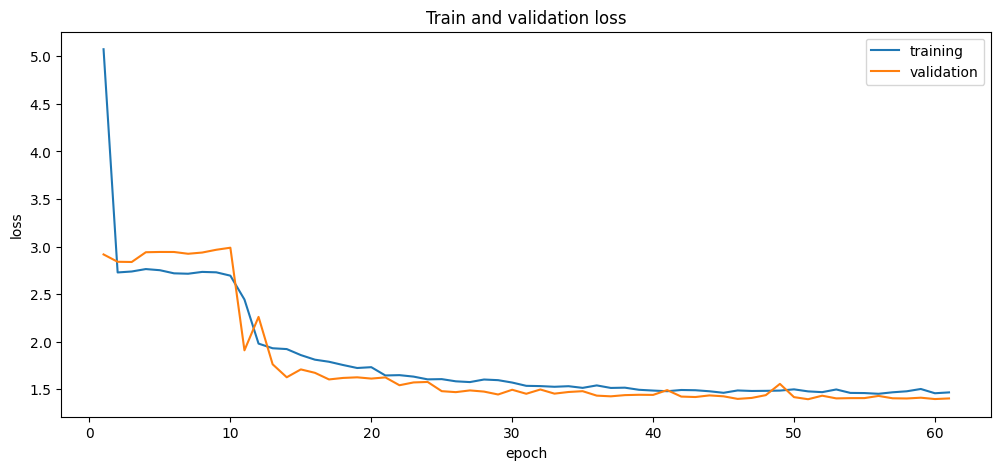

In [32]:
loss_df = pd.DataFrame({"training": training_loss, "validation":validation_loss , "epoch": epoch_nums})
loss_df.set_index('epoch')[['training', 'validation']].plot(figsize=(12, 5), title="Train and validation loss", 
          xlabel='epoch', ylabel='loss');

In [33]:
def compute_metrics(true_series, forecast):
    
    mse = np.mean(np.power(true_series.values-forecast,2))
    mae = np.mean(np.abs(true_series.values-forecast))

    return mse, mae

In [34]:
def model_forecast(model, series, window_size):
    forecast = []
    ds = []

    for i in range(len(series)-window_size):
        ds.append(series[i:i+window_size])

    for i in ds:
        forecast.append(float(model(torch.Tensor(i).unsqueeze(0)).data.numpy()))
    return forecast

In [35]:
def model_forecast(model, series, window_size):
    forecast = []
    ds = []
    for i in range(len(series) - window_size):
        ds.append(series[i:i + window_size])

    model = model.to(device)  # Ensure model is on the correct device

    for i in ds:
        input_tensor = torch.Tensor(i).unsqueeze(0).to(device)  # Move input tensor to the same device as model
        with torch.no_grad():
            output = model(input_tensor)
        forecast.append(output.cpu().numpy())  # Move output back to CPU for further processing

    return forecast

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_forecast = model_forecast(model.to(device), melbourne_temp_df['Temp'].values, WINDOW_SIZE)


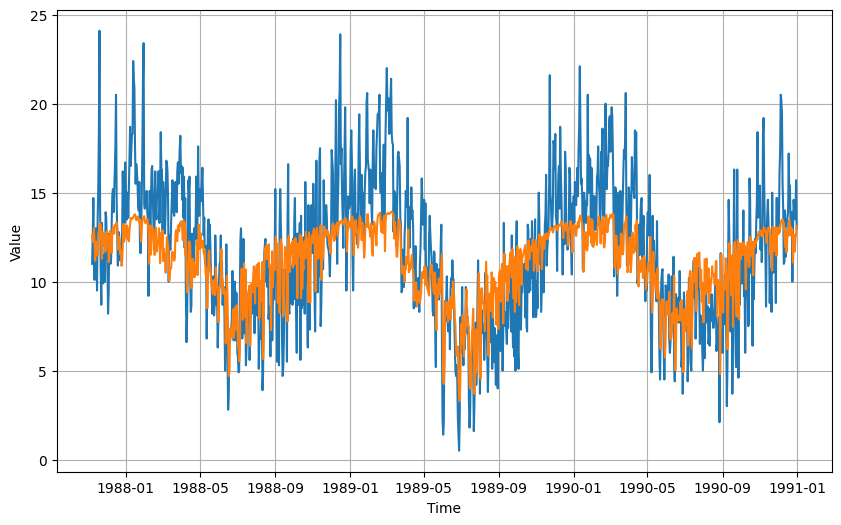

In [36]:
# Slice the forecast to get only the predictions for the validation set
y_hat = rnn_forecast[SPLIT_TIME - WINDOW_SIZE:]
y_hat = np.array(y_hat).squeeze()
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, y_val)
plot_series(time_valid, y_hat)

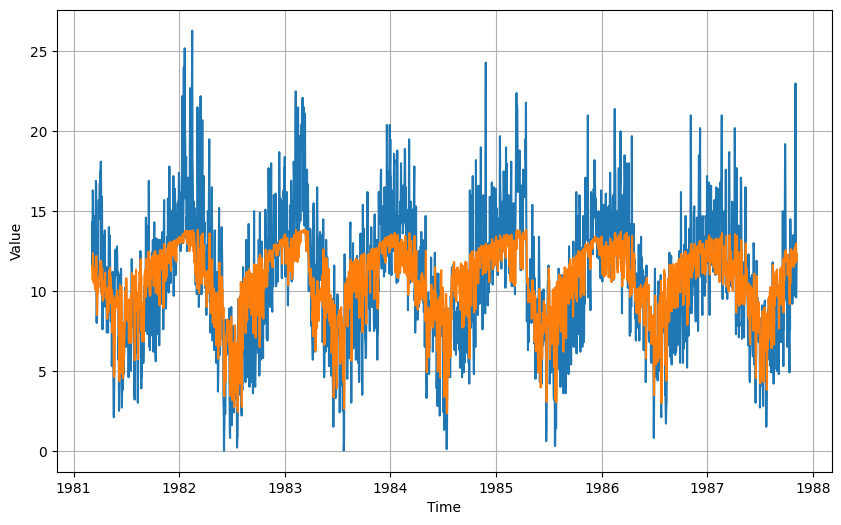

In [37]:
# Slice the forecast to get only the predictions for the validation set
y_train_hat = rnn_forecast[:SPLIT_TIME-WINDOW_SIZE]
y_train_hat = np.array(y_train_hat).squeeze()
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_train[WINDOW_SIZE:], y_train[WINDOW_SIZE:])
plot_series(time_train[WINDOW_SIZE:], y_train_hat)

In [38]:
mse, mae = compute_metrics(y_val, y_hat)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 8.66, mae: 2.33 for forecast
